In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'C:\\Users\\KBINM16696\\Desktop\\Data Science & Python\\Analytics Vidhya Hackathon Practice\\Novartis Hackerearth\\Dataset\\'

In [3]:
train = pd.read_csv(path + 'Train.csv')
test = pd.read_csv(path + 'Test.csv')
#samp = pd.read_csv(path + 'sample_submission.csv')

In [4]:
print(train.shape)
print(test.shape)

(23856, 18)
(15903, 17)


In [5]:
train.MULTIPLE_OFFENSE.value_counts()

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64

In [6]:
train.MULTIPLE_OFFENSE.value_counts(normalize=True)

1    0.955231
0    0.044769
Name: MULTIPLE_OFFENSE, dtype: float64

In [7]:
train['DATE'] = pd.to_datetime(train['DATE'])
test['DATE'] = pd.to_datetime(test['DATE'])

In [8]:
print('training data is present from {} to {}'.format(train.DATE.dt.date.min(),train.DATE.dt.date.max()))
print('test data is present from {} to {}'.format(test.DATE.dt.date.min(),test.DATE.dt.date.max()))

training data is present from 1991-01-01 to 2018-12-31
test data is present from 1991-01-02 to 2018-12-28


In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.metrics import confusion_matrix

### creating time based features

In [10]:
data_all = pd.concat([train, test])
data_all.shape

(39759, 18)

In [11]:
data_all.reset_index(inplace=True, drop=True)

In [12]:
def create_date_features(df):
    df['year'] = df['DATE'].dt.year
    df['month'] = df['DATE'].dt.month
    df['day'] = df['DATE'].dt.day
    df['DayOfWeek'] = df['DATE'].dt.dayofweek
    df['DayOfYear'] = df['DATE'].dt.dayofyear
    df['week'] = df['DATE'].dt.week
    df['Quarter'] = df['DATE'].dt.quarter
    df['is_month_start'] = df['DATE'].dt.is_month_start
    df['is_month_end'] = df['DATE'].dt.is_month_end
    df['is_quarter_start'] = df['DATE'].dt.is_quarter_start
    df['is_quarter_end'] = df['DATE'].dt.is_quarter_end
    df['is_year_start'] = df['DATE'].dt.is_year_start
    df['is_year_end'] = df['DATE'].dt.is_year_end
    df['Semester'] = np.where(df['Quarter'].isin([1,2]),1,2)
    df['is_weekend'] = np.where(df['DayOfWeek'].isin([5,6]), 1,0)
    df['is_weekday'] = np.where(df['DayOfWeek'].isin([0,1,2,3,4]), 1,0)
    return df

In [13]:
data_all = create_date_features(data_all)
data_all.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,Quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,Semester,is_weekend,is_weekday
0,CR_102659,2004-07-04,0,36,34,2,1,5,6,1,...,3,False,False,False,False,False,False,2,1,0
1,CR_189752,2017-07-18,1,37,37,0,0,11,17,1,...,3,False,False,False,False,False,False,2,0,1
2,CR_184637,2017-03-15,0,3,2,3,5,1,0,2,...,1,False,False,False,False,False,False,1,0,1
3,CR_139071,2009-02-13,0,33,32,2,1,7,1,1,...,1,False,False,False,False,False,False,1,0,1
4,CR_109335,2005-04-13,0,33,32,2,1,8,3,0,...,2,False,False,False,False,False,False,1,0,1


In [14]:
train.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
count,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23674.000000,23856.000000,23856.000000,23856.000000,23856.000000
mean,0.483778,24.791206,24.637450,4.276744,2.455609,6.154175,4.876509,0.972460,4.924128,1.244802,206.954519,0.974064,85.237383,72.674296,33.464747,0.955231
std,1.439738,15.240231,15.135093,2.944672,1.963095,4.471756,3.881931,1.453144,1.362625,1.119301,93.033348,1.167725,27.597226,43.297320,8.386834,0.206800
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000,1.000000
50%,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000,1.000000
75%,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000,1.000000
max,7.000000,52.000000,52.000000,10.000000,5.000000,19.000000,18.000000,99.000000,6.000000,90.000000,332.000000,90.000000,116.000000,142.000000,50.000000,1.000000


#### create variables around missing value of X_12

In [15]:
data_all['is_X_12_missing'] = np.where(data_all.X_12.isnull(),1,0)

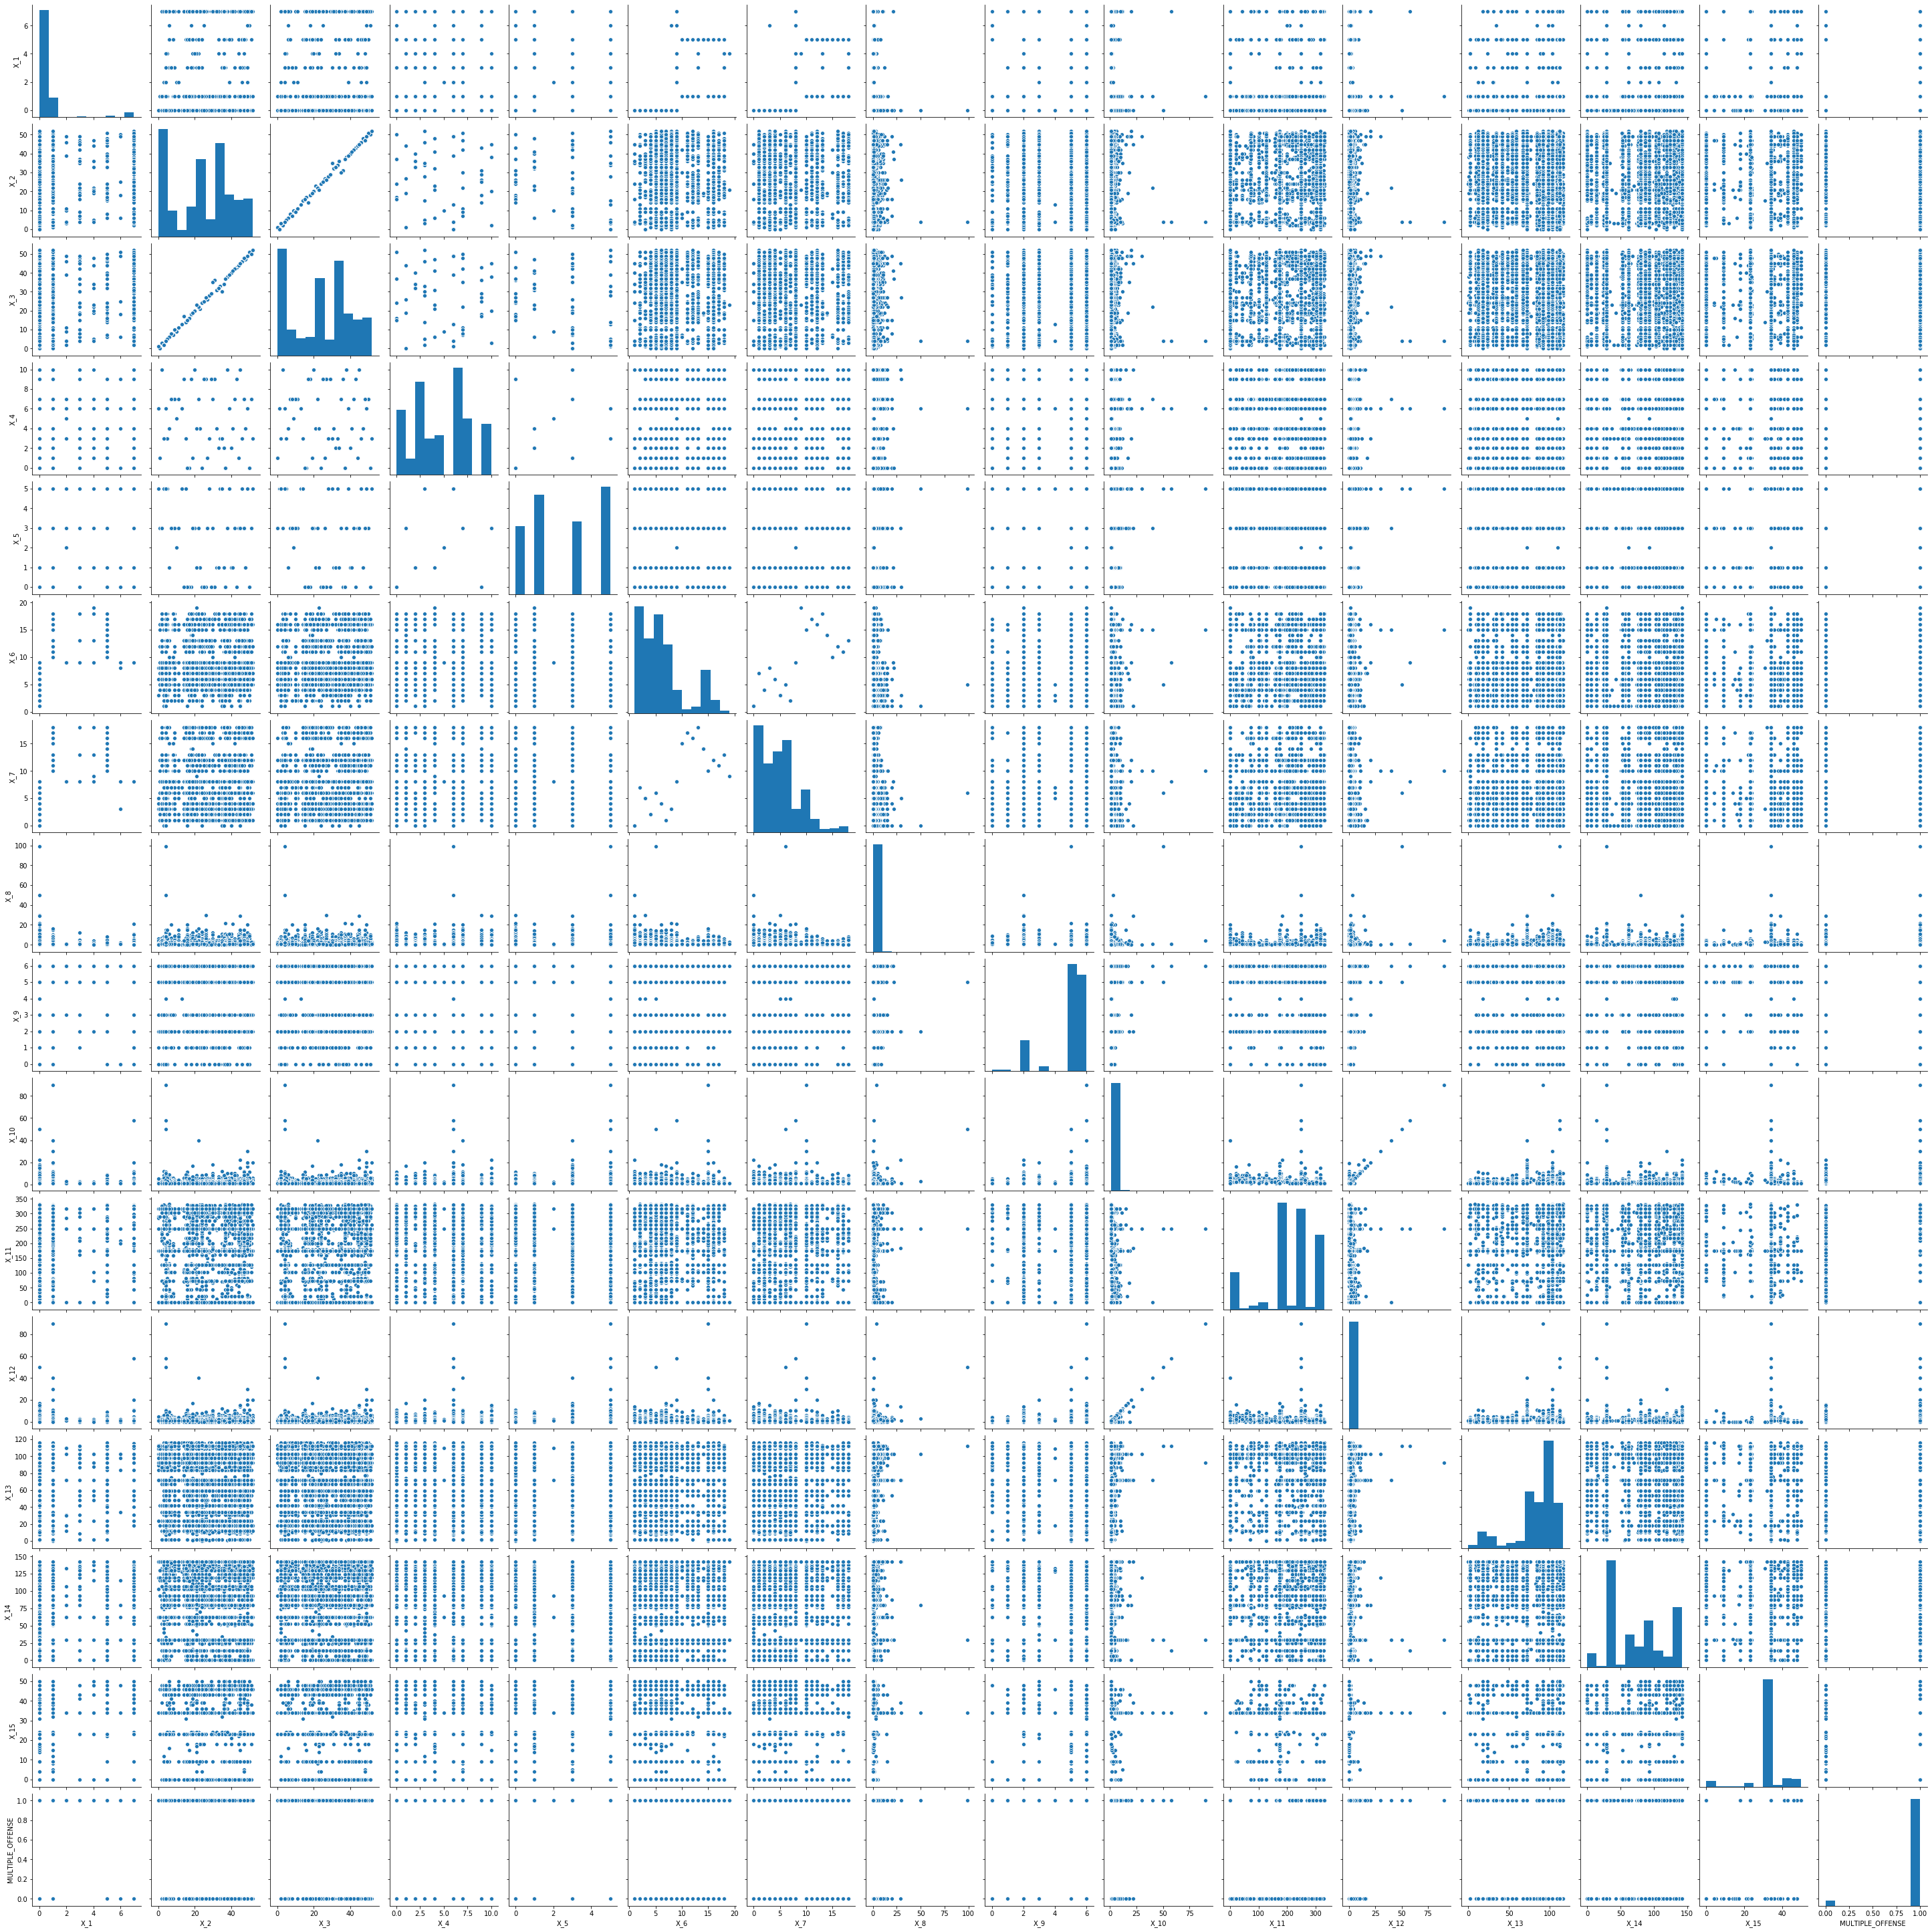

In [26]:
import seaborn as sns
sns.pairplot(train)

In [50]:
print(data_all.shape)

(39759, 35)


In [51]:
### datewise count of multiple offence
dft = data_all.groupby('DATE')['MULTIPLE_OFFENSE'].sum().reset_index(drop=False)
data_all = pd.merge(data_all, dft, how='left', on='DATE')

In [57]:
data_all.rename(columns={'MULTIPLE_OFFENSE_y':'cnt_total_offence'}, inplace=True)

In [92]:
data_all.rename(columns={'MULTIPLE_OFFENSE_x':'MULTIPLE_OFFENSE'}, inplace=True)

### Some More EDA and Feature Engineering

In [16]:
check1 = data_all[~(data_all.MULTIPLE_OFFENSE.isnull())]

In [17]:
check1.shape

(23856, 35)

In [18]:
data_all.columns

Index(['INCIDENT_ID', 'DATE', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15',
       'MULTIPLE_OFFENSE', 'year', 'month', 'day', 'DayOfWeek', 'DayOfYear',
       'week', 'Quarter', 'is_month_start', 'is_month_end', 'is_quarter_start',
       'is_quarter_end', 'is_year_start', 'is_year_end', 'Semester',
       'is_weekend', 'is_weekday', 'is_X_12_missing'],
      dtype='object')

In [33]:
check1.groupby('is_X_12_missing')['MULTIPLE_OFFENSE'].mean().sort_values(ascending=False)

is_X_12_missing
1    1.000000
0    0.954887
Name: MULTIPLE_OFFENSE, dtype: float64

In [104]:
check1.groupby('month')['MULTIPLE_OFFENSE'].mean().sort_values(ascending=False)

month
9     0.965939
2     0.959767
11    0.958446
7     0.957348
3     0.957286
8     0.956398
10    0.955098
6     0.954094
4     0.952696
12    0.949164
1     0.947671
5     0.946312
Name: MULTIPLE_OFFENSE, dtype: float64

In [27]:
train.MULTIPLE_OFFENSE.value_counts(normalize=True)

1    0.955231
0    0.044769
Name: MULTIPLE_OFFENSE, dtype: float64

In [31]:
round(train.MULTIPLE_OFFENSE.mean(),4)

0.9552

In [35]:
data_all.groupby('DATE')['MULTIPLE_OFFENSE'].sum().sort_values(ascending=False)

DATE
2001-09-12    20.0
2001-09-13    19.0
2001-09-11    15.0
2001-09-17    15.0
2001-09-15    14.0
              ... 
2006-02-08     0.0
2002-08-27     0.0
2014-06-27     0.0
2010-02-14     0.0
2013-09-20     0.0
Name: MULTIPLE_OFFENSE, Length: 9942, dtype: float64

In [86]:
check1.groupby('X_6')['MULTIPLE_OFFENSE'].mean()

X_6
1     0.950881
2     0.962576
3     0.949063
4     0.952997
5     0.957447
6     0.957779
7     0.963692
8     0.953737
9     0.969219
10    0.880000
11    0.945000
12    0.923810
13    0.956835
14    0.944444
15    0.950820
16    0.941935
17    0.936364
18    0.938272
19    1.000000
Name: MULTIPLE_OFFENSE, dtype: float64

In [60]:
check1['X_12'] = np.where(check1['X_12']>4, '4+', check1['X_12'])

In [88]:
check1.X_6.value_counts()

1     3461
5     2679
6     2629
4     2319
15    2318
2     2298
7     2286
3     1708
8     1405
9     1267
16     620
12     210
11     200
18     162
13     139
17     110
10      25
14      18
19       2
Name: X_6, dtype: int64

### missing value treatment

In [64]:
data_all['X_12'].fillna(data_all.X_12.value_counts().idxmax(), inplace=True)

In [43]:
## missing value filled with mode value

In [65]:
### transform X_12 columns and group the 4+ values in the same category
### transform X_10 columns and group the 4+ values in the same category
data_all['X_12'] = np.where(data_all['X_12']>4, '4+', data_all['X_12'])
data_all['X_10'] = np.where(data_all['X_10']>4, '4+', data_all['X_10'])

In [89]:
data_all.columns

Index(['INCIDENT_ID', 'DATE', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15',
       'MULTIPLE_OFFENSE_x', 'year', 'month', 'day', 'DayOfWeek', 'DayOfYear',
       'week', 'Quarter', 'is_month_start', 'is_month_end', 'is_quarter_start',
       'is_quarter_end', 'is_year_start', 'is_year_end', 'Semester',
       'is_weekend', 'is_weekday', 'is_X_12_missing', 'cnt_total_offence'],
      dtype='object')

In [93]:
train1 = data_all.loc[~(data_all.MULTIPLE_OFFENSE.isnull())]
test1 = data_all.loc[(data_all.MULTIPLE_OFFENSE.isnull())]
print(train1.shape)
print(test1.shape)

(23856, 36)
(15903, 36)


In [94]:
test1.reset_index(inplace=True, drop=True)
test1.drop('MULTIPLE_OFFENSE', axis=1, inplace=True)
test1.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,Semester,is_weekend,is_weekday,is_X_12_missing,cnt_total_offence
0,CR_195453,2018-02-01,0,30,35,7,3,6,4,0,...,False,False,False,False,False,1,0,1,1,5.0
1,CR_103520,2004-03-05,0,44,44,1,3,7,1,4,...,False,False,False,False,False,1,0,1,0,4.0
2,CR_196089,2018-01-27,0,34,33,3,5,2,7,3,...,False,False,False,False,False,1,1,0,0,3.0
3,CR_112195,2006-08-18,7,3,2,3,5,9,8,0,...,False,False,False,False,False,2,0,1,0,1.0
4,CR_149832,2011-10-31,0,7,8,7,3,2,7,1,...,True,False,False,False,False,2,0,1,0,1.0


### target encoding or impact encoding for X_10 and X_12

In [96]:
from sklearn.model_selection import KFold

In [97]:
# This way we have randomness and are able to reproduce the behaviour within this cell.
np.random.seed(13)

def impact_coding(data, feature, target='y'):
    '''
    In this implementation we get the values and the dictionary as two different steps.
    This is just because initially we were ignoring the dictionary as a result variable.
    
    In this implementation the KFolds use shuffling. If you want reproducibility the cv 
    could be moved to a parameter.
    '''
    n_folds = 10
    n_inner_folds = 5
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold].apply(
                            lambda x: oof_mean[x[feature]]
                                      if x[feature] in oof_mean.index
                                      else oof_default_inner_mean
                            , axis=1))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof].apply(
                            lambda x: inner_oof_mean_cv.loc[x[feature]].mean()
                                      if x[feature] in inner_oof_mean_cv.index
                                      else oof_default_mean
                            , axis=1))

    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean

In [106]:
categorical_features_to_encode = ['X_10','X_12']

In [107]:
impact_coding_map = {}
for f in categorical_features_to_encode:
    print("Impact coding for {}".format(f))
    train1["impact_encoded_{}".format(f)], impact_coding_mapping, default_coding = impact_coding(train1, f, 'MULTIPLE_OFFENSE')
    impact_coding_map[f] = (impact_coding_mapping, default_coding)
    mapping, default_mean = impact_coding_map[f]
    test1["impact_encoded_{}".format(f)] = test1.apply(lambda x: mapping[x[f]]
                                                                         if x[f] in mapping
                                                                         else default_mean
                                                               , axis=1)

Impact coding for X_10
Impact coding for X_12


In [123]:
test1.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,is_quarter_end,is_year_start,is_year_end,Semester,is_weekend,is_weekday,is_X_12_missing,cnt_total_offence,impact_encoded_X_10,impact_encoded_X_12
0,CR_195453,2018-02-01,0,30,35,7,3,6,4,0,...,False,False,False,1,0,1,1,5.0,0.994503,0.965373
1,CR_103520,2004-03-05,0,44,44,1,3,7,1,4,...,False,False,False,1,0,1,0,4.0,0.994503,0.979154
2,CR_196089,2018-01-27,0,34,33,3,5,2,7,3,...,False,False,False,1,1,0,0,3.0,0.994503,0.965373
3,CR_112195,2006-08-18,7,3,2,3,5,9,8,0,...,False,False,False,2,0,1,0,1.0,0.994503,0.965373
4,CR_149832,2011-10-31,0,7,8,7,3,2,7,1,...,False,False,False,2,0,1,0,1.0,0.994503,0.979154


### columns to one hot encode and standard scalar

In [114]:
columns_to_avoid = ['INCIDENT_ID', 'X_10', 'X_12']

In [116]:
cols_to_ohe = train1.select_dtypes(include=['object','bool']).columns.difference(columns_to_avoid)

In [117]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
ohe = OneHotEncoder()
st = StandardScaler()

In [121]:
cols_to_stand_scalar = ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_11', 'X_13', 'X_14', 'X_15']

In [128]:
cols_not_taken = ['INCIDENT_ID', 'DATE', 'MULTIPLE_OFFENSE']

In [129]:
X1 = train1[train1.columns.difference(cols_not_taken)]
y1 = train['MULTIPLE_OFFENSE']
X_test1 = test1[test1.columns.difference(cols_not_taken)]
print(X1.shape)
print(y1.shape)
print(X_test1.shape)

(23856, 35)
(23856,)
(15903, 35)


In [130]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le = LabelEncoder()
y1 = le.fit_transform(y1)

In [131]:
ohe_vars = pd.DataFrame(ohe.fit_transform(X1[cols_to_ohe]).toarray())
ohe_vars.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [132]:
ohe_vars1 = pd.DataFrame(ohe.transform(X_test1[cols_to_ohe]).toarray())
ohe_vars1.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [134]:
X1.drop(cols_to_ohe, axis=1, inplace=True)
X_test1.drop(cols_to_ohe, axis=1, inplace=True)
print(X1.shape)
print(X_test1.shape)

(23856, 29)
(15903, 29)


In [137]:
## standard scalar
for col in cols_to_stand_scalar:
    X1[col] = st.fit_transform(X1[col].values.reshape(-1,1))
    X_test1[col] = st.transform(X_test1[col].values.reshape(-1,1))

In [141]:
cols_to_stand_scalar1 = ['DayOfWeek', 'DayOfYear', 'Quarter','cnt_total_offence', 'day']
for col in cols_to_stand_scalar1:
    X1[col] = st.fit_transform(X1[col].values.reshape(-1,1))
    X_test1[col] = st.transform(X_test1[col].values.reshape(-1,1))

In [143]:
cols_to_stand_scalar2 = ['Semester','month', 'week', 'year']
for col in cols_to_stand_scalar2:
    X1[col] = st.fit_transform(X1[col].values.reshape(-1,1))
    X_test1[col] = st.transform(X_test1[col].values.reshape(-1,1))

In [146]:
print(X1.shape)
print(X_test1.shape)
X1.drop(categorical_features_to_encode, axis=1, inplace=True)
X_test1.drop(categorical_features_to_encode, axis=1, inplace=True)
print(X1.shape)
print(X_test1.shape)

(23856, 29)
(15903, 29)
(23856, 27)
(15903, 27)


In [147]:
X1.head()

,DayOfWeek,DayOfYear,Quarter,Semester,X_1,X_11,X_13,X_14,X_15,X_2,...,cnt_total_offence,day,impact_encoded_X_10,impact_encoded_X_12,is_X_12_missing,is_weekday,is_weekend,month,week,year
0,1.513553,0.034626,0.456891,0.990405,-0.336025,-0.354230,0.245052,-1.008728,0.302296,0.735489,...,-1.257543,-1.317853,0.994504,0.965373,0,0,1,0.149118,0.029776,-0.031959
1,-0.992681,0.163838,0.456891,0.990405,0.358561,0.312212,0.643651,1.601188,0.063822,0.801107,...,0.885923,0.277523,0.994504,0.965372,0,1,0,0.149118,0.168932,1.635773
2,-0.491435,-1.078580,-1.395050,-1.009688,-0.336025,-0.354230,0.897305,0.469455,0.063822,-1.429877,...,-0.721677,-0.064344,0.994504,0.965373,0,1,0,-1.065309,-1.083477,1.635773
3,0.511059,-1.376760,-1.395050,-1.009688,-0.336025,0.451949,-0.479674,-1.008728,0.063822,0.538638,...,-0.185810,-0.292254,0.994503,0.965372,0,1,0,-1.368916,-1.361790,0.609476
4,-0.491435,-0.790339,-0.469079,-1.009688,-0.336025,-0.354230,0.969778,-1.008728,1.136955,0.538638,...,0.885923,-0.292254,0.994503,0.979154,0,1,0,-0.761702,-0.805164,0.096328


In [148]:
## concat ohe variables with the remaining independent variables

X1 = pd.concat([X1, ohe_vars], axis=1)
X_test1 = pd.concat([X_test1, ohe_vars1], axis=1)
print(X1.shape)
print(X_test1.shape)

(23856, 39)
(15903, 39)


#### catboost without converting categorical columns

In [149]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier()
cb.fit(X1, y1)
pred = cb.predict(X_test1)

Learning rate set to 0.039918
0:	learn: 0.5970811	total: 152ms	remaining: 2m 31s
1:	learn: 0.5118915	total: 205ms	remaining: 1m 42s
2:	learn: 0.4505580	total: 271ms	remaining: 1m 30s
3:	learn: 0.4029621	total: 319ms	remaining: 1m 19s
4:	learn: 0.3501771	total: 363ms	remaining: 1m 12s
5:	learn: 0.3117039	total: 420ms	remaining: 1m 9s
6:	learn: 0.2928843	total: 450ms	remaining: 1m 3s
7:	learn: 0.2763053	total: 480ms	remaining: 59.6s
8:	learn: 0.2464529	total: 504ms	remaining: 55.5s
9:	learn: 0.2343334	total: 529ms	remaining: 52.3s
10:	learn: 0.2229233	total: 552ms	remaining: 49.6s
11:	learn: 0.1907808	total: 576ms	remaining: 47.4s
12:	learn: 0.1772242	total: 601ms	remaining: 45.6s
13:	learn: 0.1622961	total: 625ms	remaining: 44s
14:	learn: 0.1513568	total: 650ms	remaining: 42.7s
15:	learn: 0.1415840	total: 673ms	remaining: 41.4s
16:	learn: 0.1338102	total: 698ms	remaining: 40.3s
17:	learn: 0.1250095	total: 721ms	remaining: 39.4s
18:	learn: 0.1154317	total: 745ms	remaining: 38.5s
19:	lear

165:	learn: 0.0076160	total: 4.86s	remaining: 24.4s
166:	learn: 0.0074828	total: 4.89s	remaining: 24.4s
167:	learn: 0.0074719	total: 4.91s	remaining: 24.3s
168:	learn: 0.0074218	total: 4.93s	remaining: 24.3s
169:	learn: 0.0073732	total: 4.96s	remaining: 24.2s
170:	learn: 0.0071700	total: 4.98s	remaining: 24.2s
171:	learn: 0.0071207	total: 5.01s	remaining: 24.1s
172:	learn: 0.0070886	total: 5.04s	remaining: 24.1s
173:	learn: 0.0070734	total: 5.06s	remaining: 24s
174:	learn: 0.0070236	total: 5.08s	remaining: 24s
175:	learn: 0.0068443	total: 5.11s	remaining: 23.9s
176:	learn: 0.0068443	total: 5.12s	remaining: 23.8s
177:	learn: 0.0067917	total: 5.15s	remaining: 23.8s
178:	learn: 0.0067323	total: 5.17s	remaining: 23.7s
179:	learn: 0.0066834	total: 5.2s	remaining: 23.7s
180:	learn: 0.0066050	total: 5.22s	remaining: 23.6s
181:	learn: 0.0065163	total: 5.25s	remaining: 23.6s
182:	learn: 0.0064512	total: 5.27s	remaining: 23.5s
183:	learn: 0.0063996	total: 5.29s	remaining: 23.5s
184:	learn: 0.006

334:	learn: 0.0036013	total: 8.52s	remaining: 16.9s
335:	learn: 0.0036012	total: 8.54s	remaining: 16.9s
336:	learn: 0.0036012	total: 8.55s	remaining: 16.8s
337:	learn: 0.0036012	total: 8.56s	remaining: 16.8s
338:	learn: 0.0036012	total: 8.58s	remaining: 16.7s
339:	learn: 0.0036012	total: 8.59s	remaining: 16.7s
340:	learn: 0.0036012	total: 8.61s	remaining: 16.6s
341:	learn: 0.0036012	total: 8.63s	remaining: 16.6s
342:	learn: 0.0036012	total: 8.64s	remaining: 16.6s
343:	learn: 0.0036012	total: 8.66s	remaining: 16.5s
344:	learn: 0.0036012	total: 8.67s	remaining: 16.5s
345:	learn: 0.0036012	total: 8.69s	remaining: 16.4s
346:	learn: 0.0036012	total: 8.71s	remaining: 16.4s
347:	learn: 0.0036012	total: 8.72s	remaining: 16.3s
348:	learn: 0.0036012	total: 8.74s	remaining: 16.3s
349:	learn: 0.0036012	total: 8.76s	remaining: 16.3s
350:	learn: 0.0036011	total: 8.77s	remaining: 16.2s
351:	learn: 0.0036011	total: 8.79s	remaining: 16.2s
352:	learn: 0.0036011	total: 8.8s	remaining: 16.1s
353:	learn: 0

501:	learn: 0.0036008	total: 11s	remaining: 10.9s
502:	learn: 0.0036008	total: 11s	remaining: 10.9s
503:	learn: 0.0036008	total: 11.1s	remaining: 10.9s
504:	learn: 0.0036008	total: 11.1s	remaining: 10.9s
505:	learn: 0.0036008	total: 11.1s	remaining: 10.8s
506:	learn: 0.0036008	total: 11.1s	remaining: 10.8s
507:	learn: 0.0036008	total: 11.1s	remaining: 10.8s
508:	learn: 0.0036008	total: 11.1s	remaining: 10.7s
509:	learn: 0.0036008	total: 11.1s	remaining: 10.7s
510:	learn: 0.0036008	total: 11.2s	remaining: 10.7s
511:	learn: 0.0036008	total: 11.2s	remaining: 10.7s
512:	learn: 0.0036008	total: 11.2s	remaining: 10.6s
513:	learn: 0.0036008	total: 11.2s	remaining: 10.6s
514:	learn: 0.0036008	total: 11.2s	remaining: 10.6s
515:	learn: 0.0036008	total: 11.2s	remaining: 10.5s
516:	learn: 0.0036008	total: 11.3s	remaining: 10.5s
517:	learn: 0.0036008	total: 11.3s	remaining: 10.5s
518:	learn: 0.0036008	total: 11.3s	remaining: 10.5s
519:	learn: 0.0036008	total: 11.3s	remaining: 10.4s
520:	learn: 0.00

670:	learn: 0.0036008	total: 13.9s	remaining: 6.82s
671:	learn: 0.0036008	total: 13.9s	remaining: 6.79s
672:	learn: 0.0036008	total: 13.9s	remaining: 6.77s
673:	learn: 0.0036008	total: 13.9s	remaining: 6.74s
674:	learn: 0.0036008	total: 14s	remaining: 6.72s
675:	learn: 0.0036008	total: 14s	remaining: 6.7s
676:	learn: 0.0036008	total: 14s	remaining: 6.67s
677:	learn: 0.0036008	total: 14s	remaining: 6.65s
678:	learn: 0.0036008	total: 14s	remaining: 6.63s
679:	learn: 0.0036008	total: 14s	remaining: 6.6s
680:	learn: 0.0036008	total: 14s	remaining: 6.58s
681:	learn: 0.0036008	total: 14.1s	remaining: 6.56s
682:	learn: 0.0036008	total: 14.1s	remaining: 6.53s
683:	learn: 0.0036008	total: 14.1s	remaining: 6.51s
684:	learn: 0.0036008	total: 14.1s	remaining: 6.49s
685:	learn: 0.0036008	total: 14.1s	remaining: 6.46s
686:	learn: 0.0036008	total: 14.1s	remaining: 6.44s
687:	learn: 0.0036008	total: 14.1s	remaining: 6.41s
688:	learn: 0.0036008	total: 14.2s	remaining: 6.39s
689:	learn: 0.0036008	total:

832:	learn: 0.0036008	total: 16.6s	remaining: 3.32s
833:	learn: 0.0036008	total: 16.6s	remaining: 3.3s
834:	learn: 0.0036008	total: 16.6s	remaining: 3.28s
835:	learn: 0.0036008	total: 16.6s	remaining: 3.26s
836:	learn: 0.0036008	total: 16.6s	remaining: 3.24s
837:	learn: 0.0036008	total: 16.7s	remaining: 3.22s
838:	learn: 0.0036008	total: 16.7s	remaining: 3.2s
839:	learn: 0.0036008	total: 16.7s	remaining: 3.18s
840:	learn: 0.0036008	total: 16.7s	remaining: 3.16s
841:	learn: 0.0036008	total: 16.7s	remaining: 3.14s
842:	learn: 0.0036008	total: 16.7s	remaining: 3.12s
843:	learn: 0.0036008	total: 16.7s	remaining: 3.09s
844:	learn: 0.0036008	total: 16.8s	remaining: 3.07s
845:	learn: 0.0036008	total: 16.8s	remaining: 3.05s
846:	learn: 0.0036008	total: 16.8s	remaining: 3.03s
847:	learn: 0.0036008	total: 16.8s	remaining: 3.01s
848:	learn: 0.0036008	total: 16.8s	remaining: 2.99s
849:	learn: 0.0036008	total: 16.8s	remaining: 2.97s
850:	learn: 0.0036008	total: 16.8s	remaining: 2.95s
851:	learn: 0.

997:	learn: 0.0036008	total: 19.1s	remaining: 38.3ms
998:	learn: 0.0036008	total: 19.1s	remaining: 19.2ms
999:	learn: 0.0036008	total: 19.2s	remaining: 0us


In [64]:
len(pred)

15903

In [150]:
sub4 = pd.DataFrame()
sub4['INCIDENT_ID'] = test.INCIDENT_ID
sub4['MULTIPLE_OFFENSE'] = pred
sub4.to_csv(path + 'catboost_with_target_encoding1.csv', index=False)

### xgboost

In [151]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=50)

In [152]:
xgb.fit(X1, y1)
pred1 = xgb.predict(X_test1)

In [154]:
sub4 = pd.DataFrame()
sub4['INCIDENT_ID'] = test.INCIDENT_ID
sub4['MULTIPLE_OFFENSE'] = pred1
sub4.to_csv(path + 'xgb_with_target_encoded_variables1.csv', index=False)

In [156]:
### more feature engineering
X1 = pd.read_csv(path+'x.csv')
X_test1 = pd.read_csv(path + 'x_test.csv')

In [157]:
xgb.fit(X1, y1)
pred2 = xgb.predict(X_test1)

In [158]:
sub4 = pd.DataFrame()
sub4['INCIDENT_ID'] = test.INCIDENT_ID
sub4['MULTIPLE_OFFENSE'] = pred2
sub4.to_csv(path + 'xgb_with_target_encoded_variable_var2.csv', index=False)